## Introduction
This notebook builds an EEGNet model to classify states from EEG data. The process includes the steps: data input, normalization, model construction, training, and evaluation.

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## Load dataset

In [2]:
df_train = pd.read_csv('/kaggle/input/eeg-test/df_train_chia2.csv')
df_test = pd.read_csv('/kaggle/input/eeg-test/df_test_chia2.csv')
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

Train shape: (40161, 204), Test shape: (154617, 204)


In [3]:
# df_train = pd.read_csv('/kaggle/input/data-eeg/df_train.csv')
# df_test = pd.read_csv('/kaggle/input/data-eeg/df_test.csv')
# print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

In [4]:
df_train.describe()

,ED_F3_spectral_entropy,ED_F3_peak_frequency,ED_F3_mean,ED_F3_std,ED_F3_median,ED_F3_min,ED_F3_max,ED_F3_skewness,ED_F3_kurtosis,ED_F3_power_delta,...,t_wavelet_d1_energy,t_wavelet_d2_energy,t_wavelet_d3_energy,t_wavelet_d4_energy,t_wavelet_d5_energy,t_wavelet_d1_relative_energy,t_wavelet_d2_relative_energy,t_wavelet_d3_relative_energy,t_wavelet_d4_relative_energy,t_wavelet_d5_relative_energy
count,40161.000000,40161.000000,40161.000000,40161.000000,40161.000000,4.016100e+04,40161.000000,40161.000000,40161.000000,4.016100e+04,...,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04,4.016100e+04
mean,4.472824,3.038109,0.000060,0.000092,0.000034,1.448225e-06,0.000639,3.237125,17.894840,2.023739e-05,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05
std,0.667028,3.348018,0.000158,0.000394,0.000080,8.590259e-06,0.003099,1.186713,12.056169,8.771578e-04,...,5.892935e-09,1.642346e-09,7.580331e-10,1.492325e-10,3.077774e-12,3.519135e-12,3.036826e-12,1.414527e-12,2.713120e-13,5.428854e-15
min,0.544586,0.000000,0.000018,0.000020,0.000010,1.136994e-09,0.000085,-0.639453,1.474750,1.130942e-08,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05
25%,4.168443,0.500000,0.000039,0.000047,0.000025,4.674740e-07,0.000286,2.441444,10.098823,1.294526e-07,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05
50%,4.575813,1.000000,0.000045,0.000058,0.000030,8.153834e-07,0.000380,2.988121,14.288602,2.737113e-07,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05
75%,4.917679,5.000000,0.000058,0.000084,0.000036,1.377305e-06,0.000579,3.757567,21.606374,6.479580e-07,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05
max,6.604688,40.500000,0.008247,0.025928,0.004399,8.527854e-04,0.212953,10.400365,113.846762,8.790882e-02,...,4.419788e+02,8.129809e+01,4.032045e+01,4.126317e+00,1.284618e-02,7.784928e-01,1.431969e-01,7.101966e-02,7.268014e-03,2.262701e-05


In [5]:
df_train['state'].value_counts(), df_test['state'].value_counts()

(state
 drowsy       25863
 unfocused     7176
 focused       7122
 Name: count, dtype: int64,
 state
 drowsy       87893
 unfocused    33488
 focused      33236
 Name: count, dtype: int64)

## Data preprocessing

In [6]:
def preprocess_data(df, scaler, encoder):
    features = df.drop('state', axis = 1)
    labels = df['state']
    X_scaled = scaler.fit_transform(features)
    y_encoded = encoder.fit_transform(labels)
    return X_scaled, y_encoded

In [7]:
scaler = MinMaxScaler()
encoder = LabelEncoder()

# Prepare training, validation, and test data
X_train_scaled, y_train_encoded = preprocess_data(df_train, scaler, encoder)
X_test, y_test = preprocess_data(df_test, scaler, encoder)

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_encoded, 
                                                  test_size=0.2, random_state=42, stratify=y_train_encoded)

## Define and Train EEGNet Model

In [8]:
def EEGNet(nb_classes, Chans, Samples, kernLength, F1, 
             D, F2, norm_rate, dropoutRate, dropoutType):
    """ 
    Inputs:
    
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Randomly remove some neurons to avoid overfitting, passed as a string.

    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    # Block 1
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    # Block 2
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 4))(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    # Flatten and output    
    flatten      = Flatten(name = 'flatten')(block2)
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [9]:
# Model Parameters
Chans = len(["ED_F7", "ED_F3", "ED_P7", "ED_O1", "ED_O2", "ED_P8", "ED_AF4"])  # useful channels
Samples = df_train.shape[1] // Chans # Number of samples per channel

# Reshape data
X_train = X_train.reshape(-1, Chans, Samples, 1)
X_val = X_val.reshape(-1, Chans, Samples, 1)
X_test = X_test.reshape(-1, Chans, Samples, 1)

# Convert the data labels to one-hot encoded
y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

print(f"X_train shape: {X_train.shape}")  # (n_samples_train, Chans, Samples, 1)
print(f"X_val shape: {X_val.shape}")      # (n_samples_val, Chans, Samples, 1)
print(f"X_test shape: {X_test.shape}")      # (n_samples_test, Chans, Samples, 1)

X_train shape: (32128, 7, 29, 1)
X_val shape: (8033, 7, 29, 1)
X_test shape: (154617, 7, 29, 1)


In [10]:
# Initialize EEGNet model
eeg_net = EEGNet(
    nb_classes=3,       # Number of states: Focused, Unfocused, Drowsy
    Chans=Chans,           # Number of EEG channels
    Samples=Samples,        # Samples per second
    kernLength=64,      # Kernel temporal: suitable for 128Hz
    F1=8,              # Number of temporal filters
    D=2,                # Spatial Filter
    F2=16,              # Total filter number
    norm_rate= 0.25,     # Constraint level for the kernel of the Dense layer.
    dropoutRate=0.5,    # Dropout to avoid overfitting
    dropoutType='Dropout'
)

# Compile EEGNet model
eeg_net.compile(
    loss='categorical_crossentropy',  # Multi-layer classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with low learning rate
    metrics=['accuracy']  # Evaluate by accuracy
)

# Train model
history = eeg_net.fit(
    X_train, 
    y_train_onehot, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val_onehot) # Use validation_data to validate in each epoch
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7519 - loss: 0.6316 - val_accuracy: 0.8829 - val_loss: 0.3144
Epoch 2/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8754 - loss: 0.3354 - val_accuracy: 0.9375 - val_loss: 0.2275
Epoch 3/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9073 - loss: 0.2731 - val_accuracy: 0.9648 - val_loss: 0.1743
Epoch 4/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9249 - loss: 0.2384 - val_accuracy: 0.9790 - val_loss: 0.1362
Epoch 5/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9390 - loss: 0.2049 - val_accuracy: 0.9523 - val_loss: 0.1377
Epoch 6/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9428 - loss: 0.1822 - val_accuracy: 0.9892 - val_loss: 0.0982
Epoch 7/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9476 - loss: 0.1670 - val_accuracy: 0.9898 - val_loss: 0.0855
Epoch 8/50
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9509 - loss: 0.1

## Evaluation

In [11]:
# Evaluate the model on the test set
y_pred = np.argmax(eeg_net.predict(X_test), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(f"Classification Report:")
print(classification_report(y_pred, y_test))

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step
Accuracy: 0.9592606246402401
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     91611
           1       0.92      1.00      0.96     30657
           2       0.89      0.92      0.90     32349

    accuracy                           0.96    154617
   macro avg       0.94      0.96      0.95    154617
weighted avg       0.96      0.96      0.96    154617



## Visualization
#### Confusion matrix

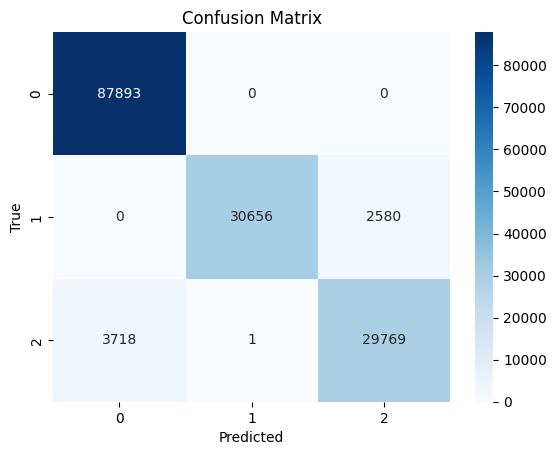

In [12]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### ROC curve

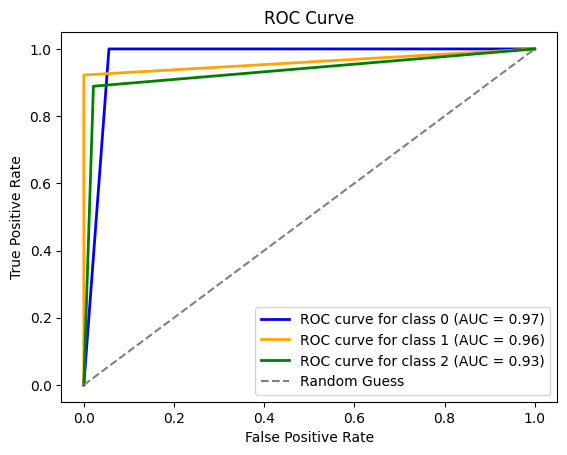

In [13]:
y_pred_onehot = to_categorical(y_pred, num_classes=3)

n_classes = 3
fpr, tpr, roc_auc = {}, {}, {}

# Calculate ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()